In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import sklearn.model_selection
import pymc3 as pm
import emcee


sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Data is from https://github.com/hwchase17/sportvu

In [2]:
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
full_DatFrame[:3]

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0


In [3]:
full_DatFrame.keys()

Index(['Unnamed: 0', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'DRIBBLES', 'FGM', 'FINAL_MARGIN', 'GAME_CLOCK',
       'GAME_ID', 'GAME_ID.1', 'LOCATION', 'MATCHUP', 'PERIOD', 'PERIOD.1',
       'PTS', 'PTS_TYPE', 'SHOT_CLOCK', 'SHOT_DIST', 'SHOT_NUMBER',
       'SHOT_RESULT', 'TOUCH_TIME', 'W', 'GRID_TYPE', 'GAME_EVENT_ID',
       'PLAYER_ID', 'PLAYER_ID.1', 'PLAYER_NAME', 'TEAM_ID',
       'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE',
       'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG'],
      dtype='object')

In [4]:
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0


In [5]:
teamID_dict = plot_court.out_teamsDict()

In [6]:
plot_court.out_teamsDict(team_abbrev='ORL')['teamId']

1610612753

In [7]:
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']

df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,TEAM_ABBREV
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0,TOR
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0,TOR


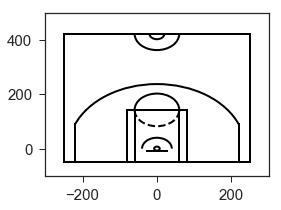

In [8]:
plt.figure(figsize=(4,3))
plot_court.draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

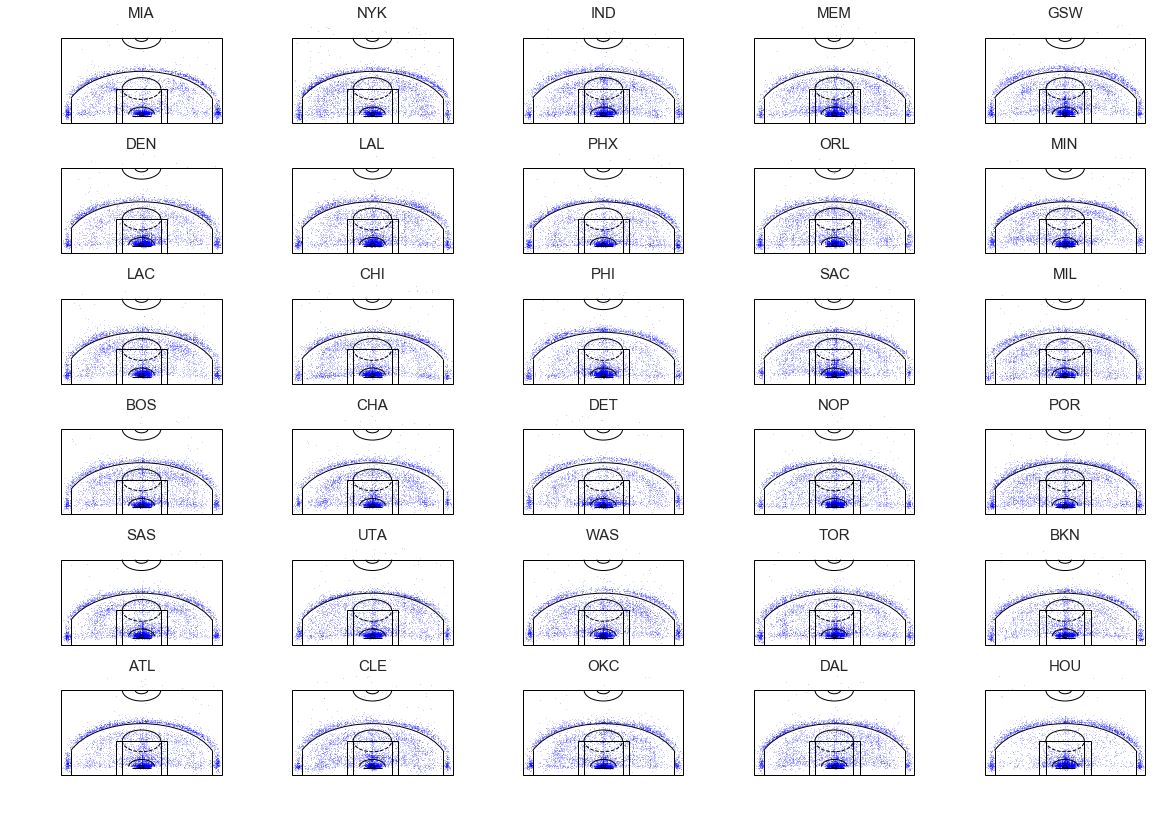

In [9]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.scatter(temp.LOC_X, temp.LOC_Y, s=0.1, c='blue', alpha=0.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s'%(team_abbrev), fontsize=15)
    plt.axis('off')
plt.show()

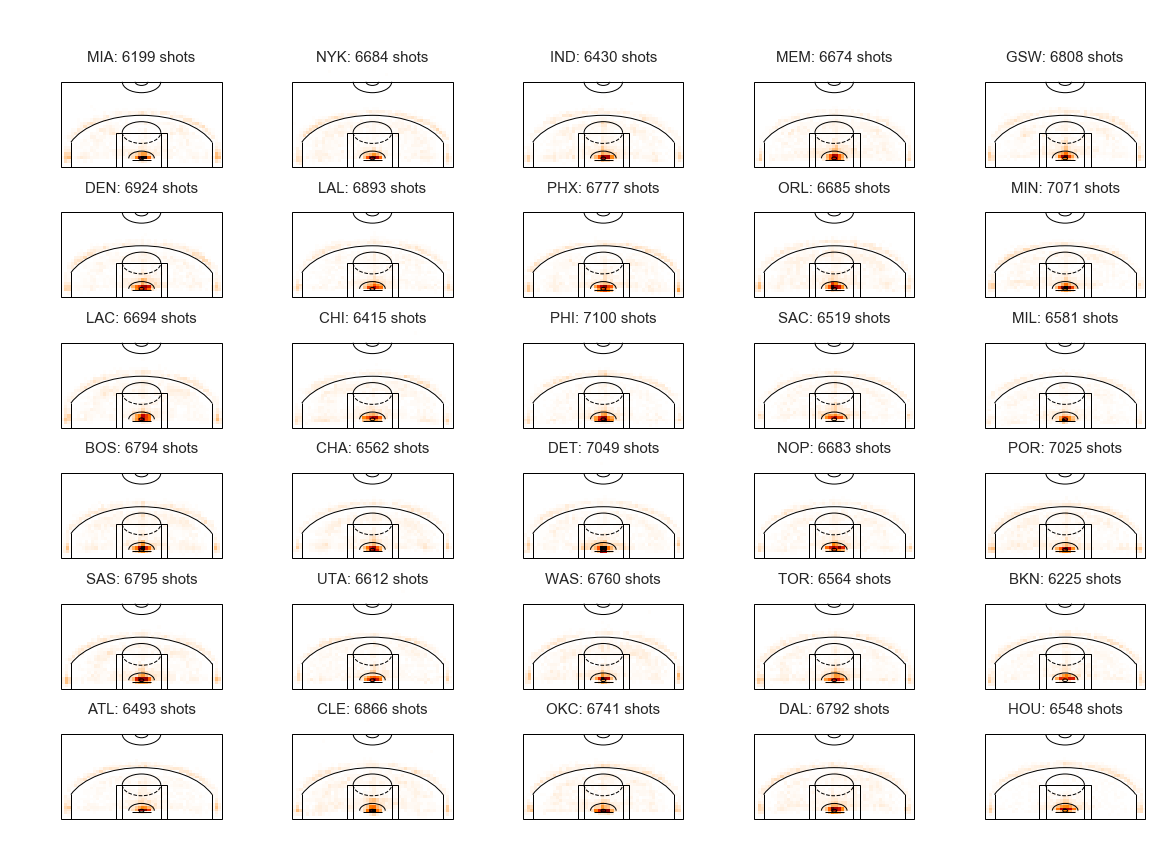

In [10]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.hist2d(temp.LOC_X, temp.LOC_Y, bins=[50,47], cmap=plt.cm.gist_heat_r, vmax=500)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: %d shots'%(team_abbrev, len(temp)), fontsize=15)
    plt.axis('off')
plt.show()

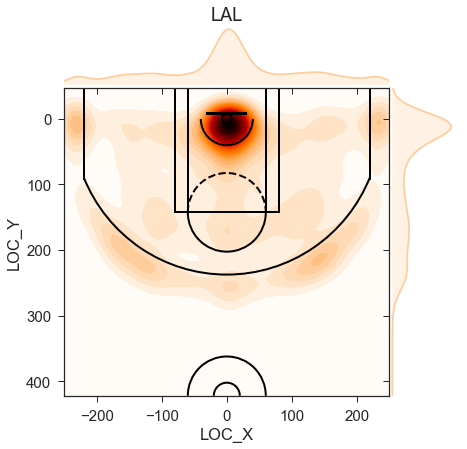

In [11]:
team_abbrev = 'LAL'
temp = df[df.TEAM_ABBREV == team_abbrev]

cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(temp.LOC_X, temp.LOC_Y, 
                                    stat_func=None,
                                    kind='kde', space=0, color=cmap(0.1),
                                    cmap=cmap, n_levels=50)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abbrev, 
             y=1.2, fontsize=18)

plt.show()

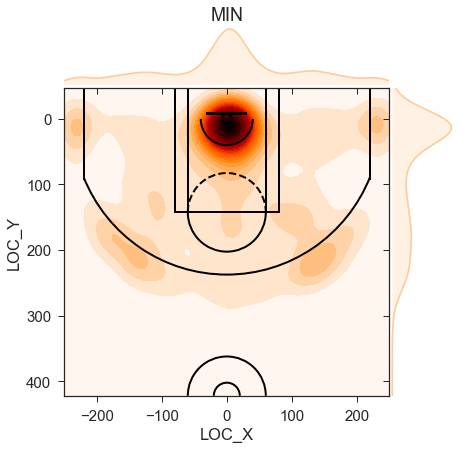

In [12]:
team_abrv = 'MIN'
temp = df[df.TEAM_ABBREV == team_abbrev]
train, test = sklearn.model_selection.train_test_split(temp, test_size = 0.2)


cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(test.LOC_X, test.LOC_Y,
                                 stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=30)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abrv, 
             y=1.2, fontsize=18)

plt.show()

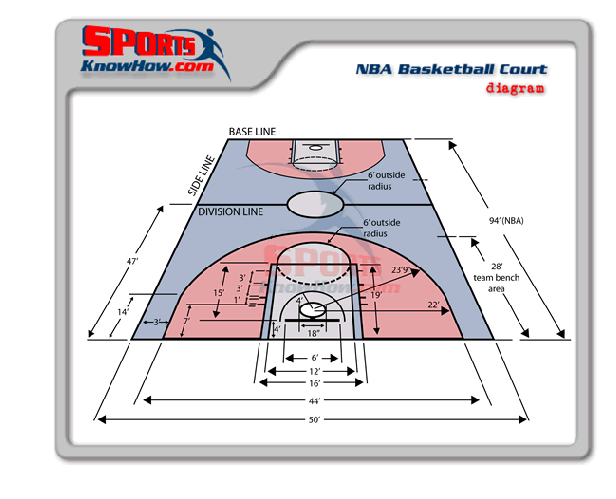

In [13]:
import urllib.request
# we pass in the link to the image as the 1st argument
# the 2nd argument tells urlretrieve what we want to scrape
pic = urllib.request.urlretrieve("http://www.sportsknowhow.com/wp-content/uploads/2015/03/basketball-NBA-court-dimensions-diagram-lrg.gif",
                                "basketball-NBA-court-dimensions-diagram-lrg.gif")

# urlretrieve returns a tuple with our image as the first 
# element and imread reads in the image as a 
# mutlidimensional numpy array so matplotlib can plot it
courtDim_pic = plt.imread(pic[0])

# plot the image
plt.figure(figsize=(10,10))
plt.imshow(courtDim_pic)
plt.axis('off')
plt.show()

In [ ]:
#team_abbrev = 'PHI'
#temp = df[df.TEAM_ABBREV == team_abbrev]
#hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
#                                                                    temp.SHOT_MADE_FLAG,
#                                                                    statistic='count',
#                                                                    bins=[50,47], 
#                                                                    range=[[-250,250], [-47.5,422.5]])
#np.max(hist2d)

In [185]:
team_abbrev = 'PHI'
temp = df[df.TEAM_ABBREV == team_abbrev]
hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                    temp.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=[20,14], 
                                                                    range=[[-250,250], [-47.5,302.5]])
np.max(hist2d)

855.0

In [186]:
XX, YY = np.meshgrid(xedges, yedges)
print(np.shape(XX), np.shape(hist2d.T))

(15, 21) (14, 20)


In [187]:
print(xedges)
print(yedges)

[-250. -225. -200. -175. -150. -125. -100.  -75.  -50.  -25.    0.   25.
   50.   75.  100.  125.  150.  175.  200.  225.  250.] [ -47.5  -22.5    2.5   27.5   52.5   77.5  102.5  127.5  152.5  177.5
  202.5  227.5  252.5  277.5  302.5]


In [279]:
binX_flat = XX.T[:-1,:-1].flatten()
binY_flat = YY.T[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

In [189]:
len(binX_flat)

280

In [205]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)
print(dist_matrix)
np.array_equal(dist_matrix, dist_matrix.transpose())

[[   0.           25.           50.         ...,  535.02336398
   555.09008278  575.54322166]
 [  25.            0.           25.         ...,  515.3882032   535.02336398
   555.09008278]
 [  50.           25.            0.         ...,  496.23583103  515.3882032
   535.02336398]
 ..., 
 [ 535.02336398  515.3882032   496.23583103 ...,    0.           25.           50.        ]
 [ 555.09008278  535.02336398  515.3882032  ...,   25.            0.           25.        ]
 [ 575.54322166  555.09008278  535.02336398 ...,   50.           25.            0.        ]]


True

In [226]:
def cov_func(dist_matrix, sigma2, phi2):
    const = sigma2
    return sigma2 * np.exp( -(dist_matrix**2) / (2 * phi2) )

phi2 = 25.**2
# sigma2 = 1./np.sqrt(2 * np.pi * phi2)
sigma2 = 3.5
cov_K = cov_func(dist_matrix, sigma2, phi2)
cov_K

array([[  3.50000000e+000,   2.12285731e+000,   4.73673491e-001, ...,
          1.23205952e-099,   3.09370041e-107,   2.85779018e-115],
       [  2.12285731e+000,   3.50000000e+000,   2.12285731e+000, ...,
          1.80505583e-092,   1.23205952e-099,   3.09370041e-107],
       [  4.73673491e-001,   2.12285731e+000,   3.50000000e+000, ...,
          9.72870667e-086,   1.80505583e-092,   1.23205952e-099],
       ..., 
       [  1.23205952e-099,   1.80505583e-092,   9.72870667e-086, ...,
          3.50000000e+000,   2.12285731e+000,   4.73673491e-001],
       [  3.09370041e-107,   1.23205952e-099,   1.80505583e-092, ...,
          2.12285731e+000,   3.50000000e+000,   2.12285731e+000],
       [  2.85779018e-115,   3.09370041e-107,   1.23205952e-099, ...,
          4.73673491e-001,   2.12285731e+000,   3.50000000e+000]])

In [227]:
det_cov_K = np.linalg.det(cov_K)
det_cov_K

16.170893736110109

In [228]:
inv_cov_K = np.linalg.inv(cov_K)
inv_cov_K

array([[  1.12287622e+00,  -1.07741924e+00,   7.55770160e-01, ...,
          6.28444593e-07,  -3.29585045e-07,   1.26363072e-07],
       [ -1.07741924e+00,   2.15667869e+00,  -1.80259382e+00, ...,
         -1.63913343e-06,   8.59636441e-07,  -3.29585045e-07],
       [  7.55770160e-01,  -1.80259382e+00,   2.66536208e+00, ...,
          3.12545879e-06,  -1.63913343e-06,   6.28444593e-07],
       ..., 
       [  6.28444593e-07,  -1.63913343e-06,   3.12545879e-06, ...,
          2.66536208e+00,  -1.80259382e+00,   7.55770160e-01],
       [ -3.29585045e-07,   8.59636441e-07,  -1.63913343e-06, ...,
         -1.80259382e+00,   2.15667869e+00,  -1.07741924e+00],
       [  1.26363072e-07,  -3.29585045e-07,   6.28444593e-07, ...,
          7.55770160e-01,  -1.07741924e+00,   1.12287622e+00]])

In [229]:
train_df = {}
test_df = {}
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):  
    temp = df[df.TEAM_ABBREV == team_abbrev]
    train_df[team_abbrev], test_df[team_abbrev] = sklearn.model_selection.train_test_split(temp, test_size = 0.2)

    
teams_shotHist_train = {}
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):  
    temp = train_df[team_abbrev]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=[20,14], 
                                                                        range=[[-250,250], [-47.5,302.5]])
    teams_shotHist_train[team_abbrev] = hist2d.flatten()
teams_shotHist_train

{'ATL': array([   2.,   42.,   91.,   41.,   22.,    5.,    3.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    6.,   15.,   12.,
           3.,    1.,    8.,   25.,    6.,    0.,    0.,    0.,    0.,
           0.,    0.,    4.,   14.,    6.,    4.,    0.,    0.,   11.,
          44.,   14.,    1.,    0.,    0.,    0.,    0.,    9.,   27.,
          21.,   11.,    5.,   10.,    5.,   14.,   58.,    8.,    1.,
           0.,    0.,    0.,    6.,   28.,    9.,   12.,   18.,   14.,
          16.,    7.,   14.,   60.,    5.,    0.,    0.,    0.,    6.,
          13.,    7.,   10.,    6.,   13.,   20.,   17.,    1.,   41.,
          33.,    2.,    0.,    0.,    8.,   17.,   15.,   11.,    3.,
           6.,   13.,   19.,   14.,   11.,   60.,    6.,    0.,    0.,
           1.,   27.,   23.,   11.,    7.,    7.,    5.,   27.,   20.,
           1.,   47.,    6.,    1.,    0.,    3.,   48.,   30.,   19.,
          14.,   16.,    4.,   20.,   18.,    1.,   31.,   15.,    0.,

In [230]:
def ln_prior(zn_v, det_cov_K, inv_cov_K):
    part1 = -np.log(2 * np.pi * (det_cov_K**0.5))
    part2 = -0.5 * np.dot(zn_v, np.dot(inv_cov_K, zn_v))
    return part1 + part2

def lambdaN_func(z0, zn_v):
    return np.exp(z0 + zn_v)

def ln_lambdaN_func(z0, zn_v):
    return z0 + zn_v

def ln_factorial(n):
    # an improvement of the Sterling Approximation of log(n!)
    # given by Srinivasa Ramanujan (Ramanujan 1988)
    # scipy.misc.factorial stops worknig at large values of n
    sterling = n * np.log(n) - n
    correct = (1./6) * np.log(n * (1 + 4*n*(1 + 2*n))) + np.log(np.pi)/2
    return sterling + correct

def ln_likelihood(z0, zn_v, Xn_v):
    part1 = -lambdaN_func(z0, zn_v)
    part2 = Xn_v * ln_lambdaN_func(z0, zn_v)
    part3 = np.nan_to_num(-ln_factorial(Xn_v))
    #print(np.sum(part1), np.sum(part2), np.sum(part3))
    #print(part3)
    return np.sum(part1 + part2 + part3)

def ln_postprob(z, Xn_v, det_cov_K, inv_cov_K):
    z0 = z[0]
    zn_v = z[1:]
    return ln_prior(zn_v, det_cov_K, inv_cov_K) + ln_likelihood(z0, zn_v, Xn_v)

In [118]:
#neg_logLike = lambda *args: -ln_postprob(*args)
#result = scipy.optimize.minimize(neg_logLike, z_guess, 
#                                 args=(Xn_v, det_cov_K, inv_cov_K))
#z0_MaxLike, zn_v_MaxLike = result["x"]

In [270]:
Xn_v = teams_shotHist_train['ATL']
z0_guess = np.log(np.mean(Xn_v))
zn_v_guess = np.zeros(len(Xn_v))
z_guess = np.append(z0_guess, zn_v_guess)

neg_logLike = lambda *args: -ln_postprob(*args)
result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                 args=(Xn_v, det_cov_K, inv_cov_K))
z_MaxLike = result["x"]
z0_MaxLike = z_MaxLike[0]
zn_MaxLike = z_MaxLike[1:]
lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
lambdaN_v

array([  3.09291382e+00,   4.20033335e+01,   9.06115048e+01,
         4.04880237e+01,   2.06139570e+01,   5.28920617e+00,
         2.13926292e+00,   6.30771993e-01,   4.58210879e-01,
         5.59960054e-01,   5.08714456e-01,   2.63950790e-01,
         3.92432942e-01,   2.65063715e-01,   4.82012852e-01,
         5.94442002e+00,   1.61175195e+01,   1.19594951e+01,
         2.70474528e+00,   1.02959954e+00,   7.07023107e+00,
         2.35380795e+01,   5.56415417e+00,   1.23841264e+00,
         1.42654015e+00,   8.46990569e-01,   4.23656248e-01,
         4.10816665e-01,   1.25567467e+00,   4.18242593e+00,
         1.25432650e+01,   7.95229742e+00,   2.82112369e+00,
         3.63742481e-01,   4.11039950e-01,   9.91062230e+00,
         4.20876402e+01,   1.29494378e+01,   2.11902046e+00,
         8.40782384e-01,   1.20267753e+00,   1.40860835e+00,
         1.65353903e+00,   8.64495377e+00,   2.54624968e+01,
         1.97824603e+01,   1.20585082e+01,   4.55019444e+00,
         7.57979800e+00,

In [280]:
LAMBDA_v = np.reshape(lambdaN_v, (20,14))
norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
bin_max = np.where(norm_lambdaN_v == np.max(norm_lambdaN_v))[0]
binXY[bin_max[0]]

array([ 0. ,  2.5])

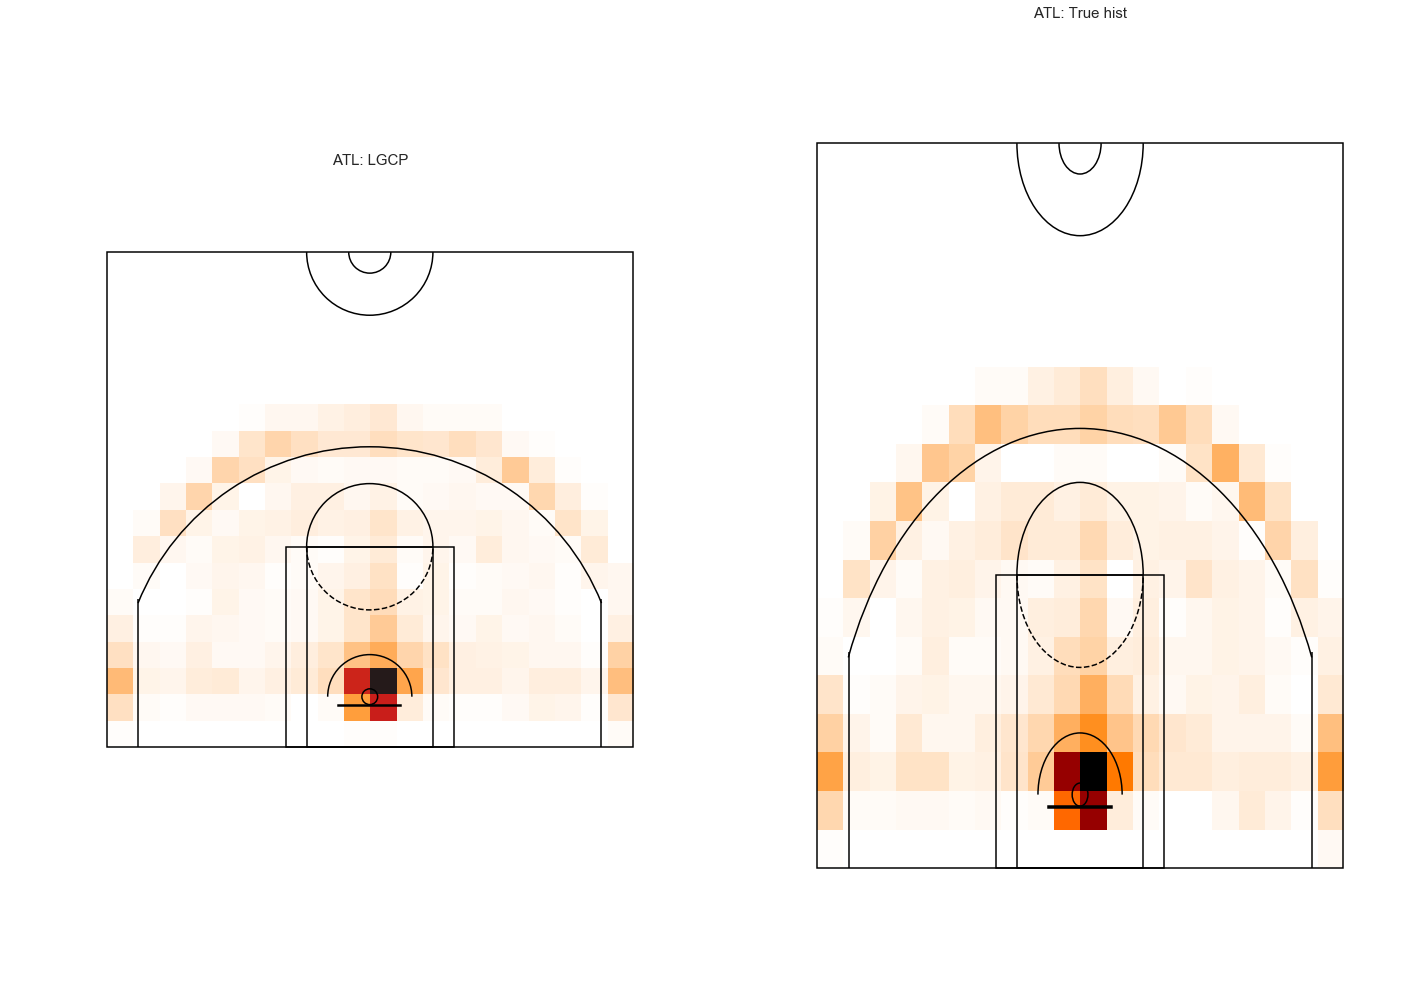

In [267]:
plt.figure(figsize=(20,14))
team_abbrev = 'ATL'
###############################################
plt.subplot(1, 2, 1)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)

plt.imshow(LAMBDA_v.T, cmap=plt.cm.gist_heat_r, alpha=.9, vmax=600,
           extent=extent)
plot_court.draw_court(outer_lines=True, lw=1.5)

plt.xlim(-300,300)
plt.ylim(-100,500)
plt.title('%s: LGCP'%(team_abbrev), fontsize=15)
plt.axis('off')

###############################################
plt.subplot(1, 2, 2)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)
    
temp = df[df.TEAM_ABBREV == team_abbrev]
plt.hist2d(temp.LOC_X, temp.LOC_Y, bins=[20,14], cmap=plt.cm.gist_heat_r, vmax=600,
           range=[[np.min(xedges), np.max(xedges)],[np.min(yedges), np.max(yedges)]])
plot_court.draw_court(outer_lines=True, lw=1.5)

plt.xlim(-300,300)
plt.ylim(-100,500)
plt.title('%s: True hist'%(team_abbrev), fontsize=15)
plt.axis('off')
###############################################
plt.tight_layout()
plt.show()

In [281]:
len(teams_shotHist_train.keys())

30

In [283]:
LL = np.zeros((30,20*14))

for i, team_abbrev in enumerate(teams_shotHist_train):
    Xn_v = teams_shotHist_train[team_abbrev]
    z0_guess = np.log(np.mean(Xn_v))
    zn_v_guess = np.zeros(len(Xn_v))
    z_guess = np.append(z0_guess, zn_v_guess)

    neg_logLike = lambda *args: -ln_postprob(*args)
    result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                     args=(Xn_v, det_cov_K, inv_cov_K))
    z_MaxLike = result["x"]
    z0_MaxLike = z_MaxLike[0]
    zn_MaxLike = z_MaxLike[1:]
    lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
    norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
    
    LL[i,:] = norm_lambdaN_v[:]

In [286]:
LL

array([[  9.28586099e-04,   1.20729662e-02,   1.98881416e-02, ...,
          1.09021993e-04,   3.07199007e-04,   2.66043250e-04],
       [  3.01024400e-03,   1.10755155e-02,   7.60060672e-03, ...,
          7.73925102e-05,   1.62499984e-04,   2.41073216e-04],
       [  8.46896515e-04,   1.21695069e-02,   8.05269542e-03, ...,
          1.00088865e-04,   1.18345597e-04,   2.04764445e-04],
       ..., 
       [  4.82225553e-04,   5.42991263e-03,   1.49864393e-02, ...,
          9.41319059e-05,   1.70239732e-04,   2.24061388e-04],
       [  6.90361501e-04,   4.25882893e-03,   1.16327926e-02, ...,
          1.32929441e-04,   1.65397004e-04,   2.01538222e-04],
       [  6.94038610e-04,   8.06969967e-03,   1.37932507e-02, ...,
          1.24124321e-04,   1.87209215e-04,   2.49960126e-04]])

In [282]:
for i, team_abbrev in enumerate(teams_shotHist_train):
    print(i, team_abbrev)

0 MIA
1 NYK
2 IND
3 MEM
4 GSW
5 DEN
6 LAL
7 PHX
8 ORL
9 MIN
10 LAC
11 CHI
12 PHI
13 SAC
14 MIL
15 BOS
16 CHA
17 DET
18 NOP
19 POR
20 SAS
21 UTA
22 WAS
23 TOR
24 BKN
25 ATL
26 CLE
27 OKC
28 DAL
29 HOU


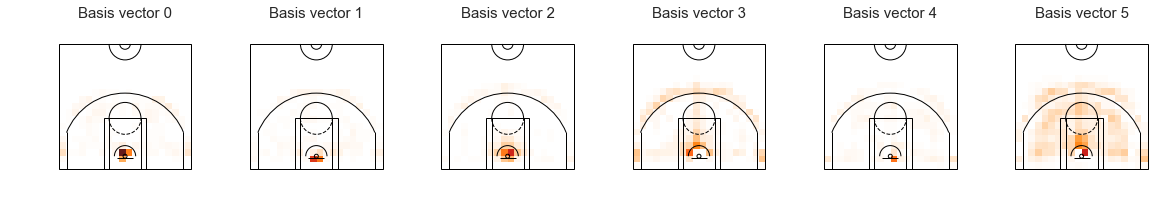

In [334]:
from sklearn.decomposition import NMF
n_comp = 6
model = NMF(n_components=n_comp, init='nndsvda')
W = model.fit_transform(LL)
H = model.components_

plt.figure(figsize=(20,14))
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)
    
    plt.imshow(H[i,:].reshape(20,14).T, cmap=plt.cm.gist_heat_r, alpha=.9, vmax=1,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

In [376]:
df_W = pd.DataFrame(W, index=teams_shotHist_train.keys(), columns = ['Basis %d'%i for i in range(n_comp)])

df_W['Playoffs'] = pd.Series(np.zeros(30, dtype='int'), index=df_W.index)
playoffTeams_east = ['IND', 'MIA', 'TOR', 'CHI', 
                     'WAS', 'BKN', 'CHA', 'ATL']
playoffTeams_west = ['SAS', 'OKC', 'LAC', 'HOU', 
                     'POR', 'GSW', 'MEM', 'DAL']
for team in playoffTeams_east:
    df_W.set_value(team,'Playoffs', 1)
for team in playoffTeams_west:
    df_W.set_value(team,'Playoffs', 1)

df_W

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Playoffs
MIA,0.234878,0.000966,0.000000,0.038615,0.067061,0.000000,1
NYK,0.132419,0.017877,0.032119,0.012517,0.059261,0.028981,0
IND,0.124770,0.048174,0.013319,0.039022,0.040445,0.026990,1
MEM,0.103546,0.072454,0.077053,0.016145,0.029035,0.023114,1
GSW,0.125671,0.000547,0.068137,0.001436,0.035903,0.041204,1
DEN,0.169551,0.033878,0.042730,0.049833,0.038249,0.003209,0
LAL,0.121269,0.020591,0.044674,0.033719,0.044158,0.024413,0
PHX,0.090192,0.114552,0.053192,0.029199,0.032668,0.012373,0
ORL,0.148814,0.015694,0.041574,0.004888,0.046291,0.032870,0
MIN,0.165596,0.052487,0.055822,0.015794,0.030403,0.012603,0


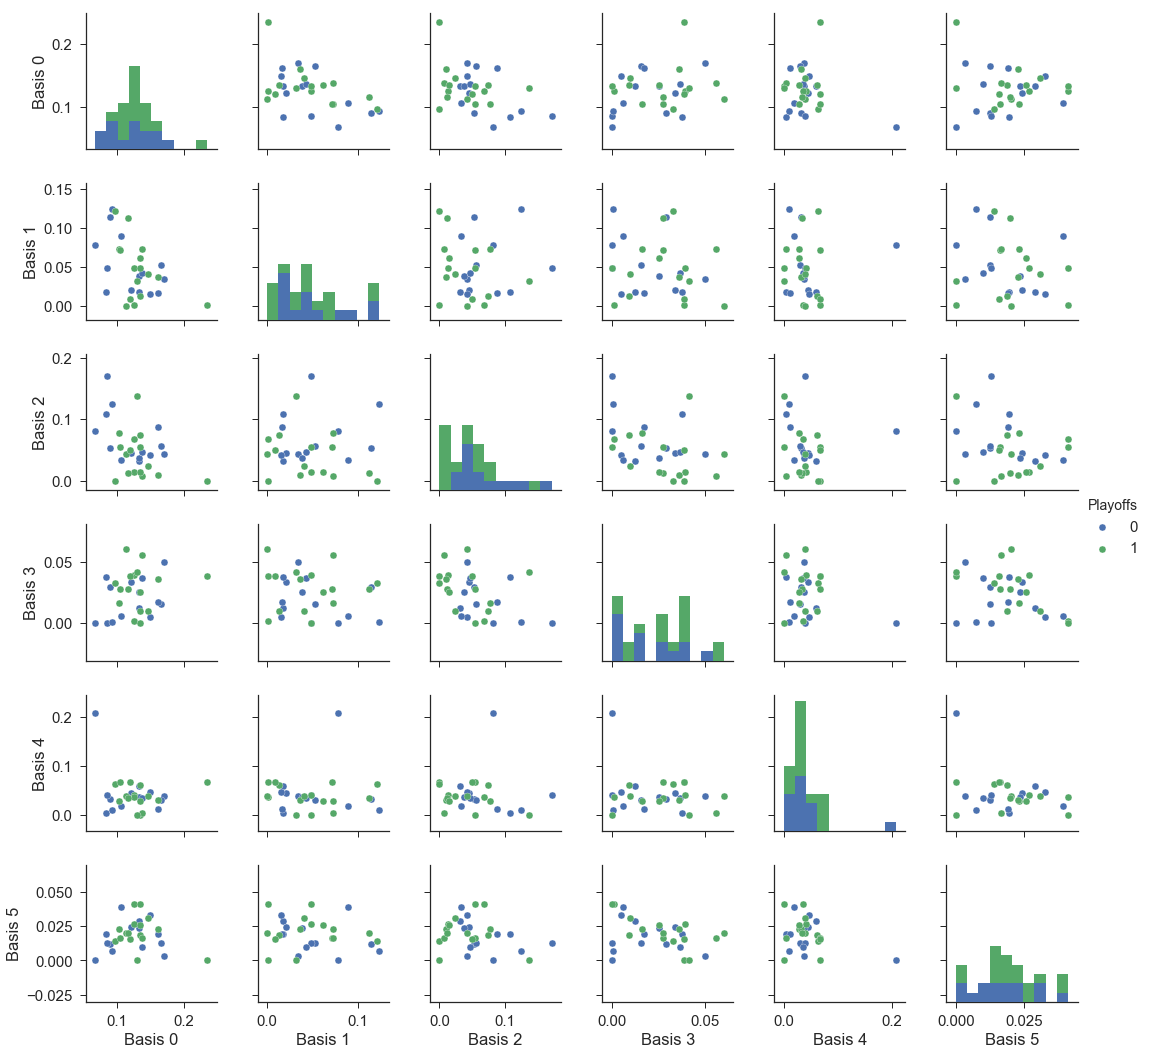

In [374]:
import seaborn as sns
sns.pairplot(df_W, vars=['Basis %d'%i for i in range(n_comp)], hue="Playoffs")
plt.show()